In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/dblp-scholar-reduced/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','dblp-scholar-reduced')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/dblp-scholar-reduced/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/dblp-scholar-reduced/glove-300.matrix.npy',
                        text_columns = ['title', 'authors', 'venue'],
                        numeric_columns = ['year'],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine'],
                        text_compositions=['average'],
                        numeric_sim_metrics=['min_max_ratio', 'scaled_inverse_lp', 'unscaled_inverse_lp'],
                        dense_nodes=[32, 16, 8],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=True,
                        embedding_trainable=True)

Number of inputs to dense layer: 14


# Train model 

In [116]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=8192,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 432038 samples, validate on 54004 samples
Epoch 1/1
432038/432038 [==============================] - 22s 51us/step - loss: 2.1312e-04 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 0.9996


# Learning curves

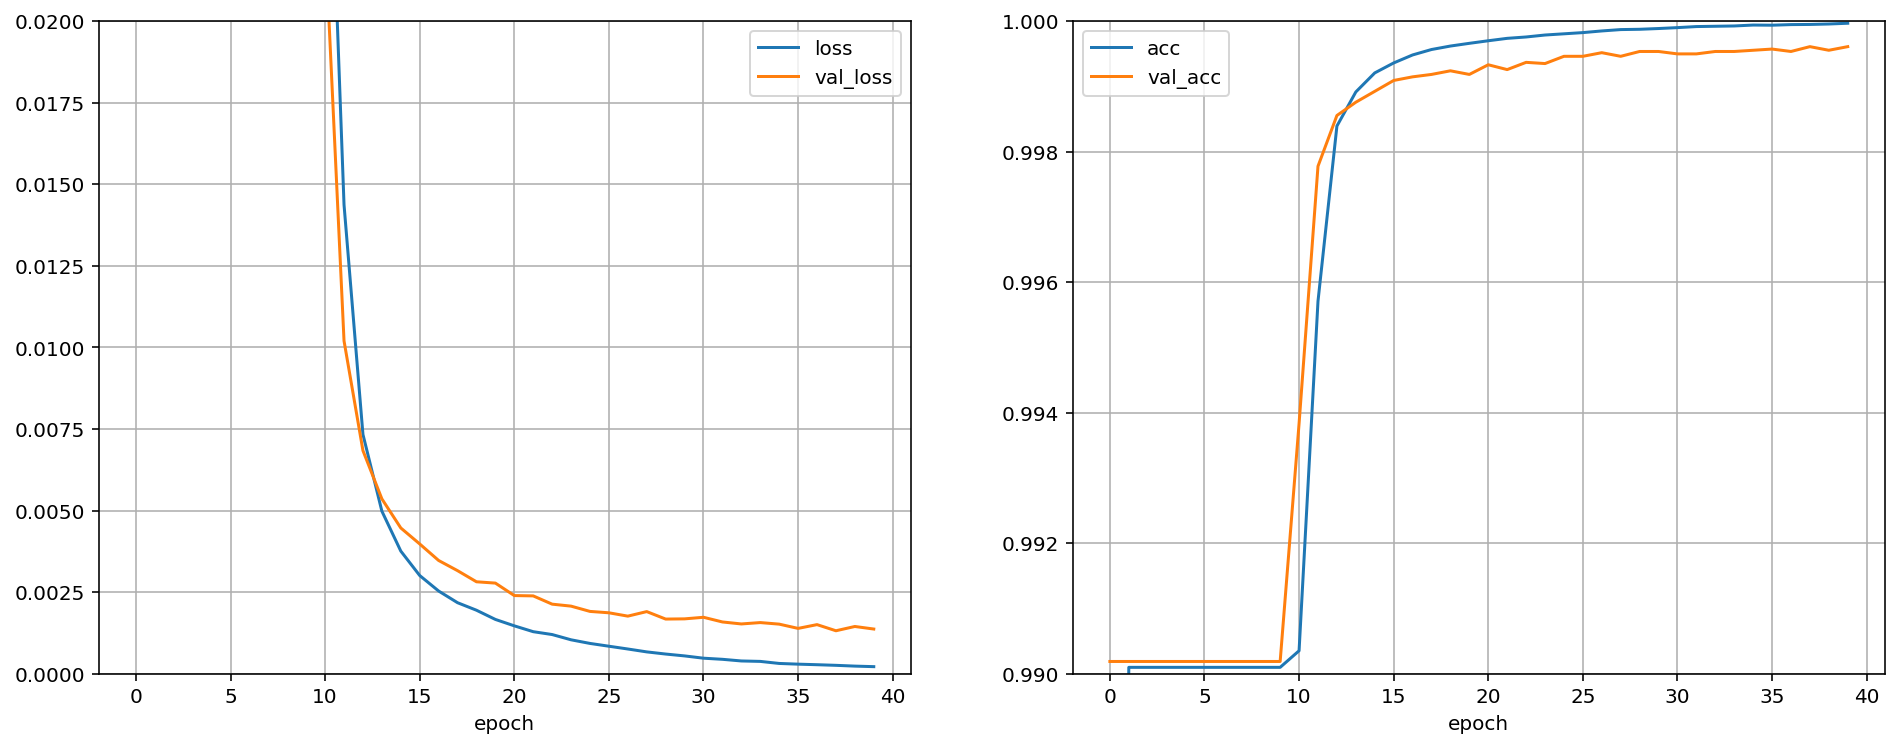

In [118]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set_ylim(0, 0.02)
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set_ylim(0.99, 1)

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [104]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     53474
          1       0.98      0.97      0.98       530

avg / total       1.00      1.00      1.00     54004

[[53465     9]
 [   14   516]]


In [105]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['title', 'authors', 'venue']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine

,id1,title,authors,venue,year,id2,title,authors,venue,year
1026,conf/vldb/AgrawalS94,fast algorithms for mining association rules in large databases,agrawal srikant,vldb,1994,3MzTom30SiMJ,fastalgorithmsformining association rules,rar srikant,of the vldb conference santiago chile september,0.0
1454,conf/sigmod/GodfreySE98,secure and portable database extensibility,godfrey mayr seshadri eicken,sigmod conference,1998,-H3tXntLhowJ,secure andportabledatabaseextensibility,godfrey mayr seshadri von eicken,acm sigmod,0.0
7157,conf/vldb/BonczMK99,database architecture optimized for the new bottleneck memory access,boncz manegold kersten,vldb,1999,6GAoBRINv7kJ,databasearchitecture optimizedforthenewbottleneck memoryaccess,boncz manegold kersten,25th international conference on very large data bases,0.0
11699,conf/sigmod/ZhaoDNS98,simultaneous optimization and evaluation of multiple dimensional queries,zhao deshpande naughton shukla,sigmod conference,1998,6AK0GF7jAtsJ,pm deshpande jf naughton shukla simultaneous optimization and evaluation of multiple,zhao,acm sigmod,0.0
13046,conf/sigmod/FaloutsosL95,fastmap fast algorithm for indexing and visualization of traditional and multimedia datasets,faloutsos lin,sigmod conference,1995,j0EcM-BvshwJ,fastmap fast algorithm for indexing,faloutsos ki lin,and visualization of traditional and multimedia,0.0
13493,conf/vldb/HellersteinNP95,generalized search trees for database systems,hellerstein naughton pfeffer,vldb,1995,SA4P684zTf4J,generalizedsearchtreesfordatabasesystems,jm hellerstein jf naughton,21st very large data bases,0.0
17181,journals/sigmod/CasatiDS00,vldb workshop on technologies in tes,nan,nan,2000,pJsnj7fi9LIJ,report on the vldb workshop on technologies for tes cairo egypt september 14 and 15,casati,sigmod record,2000.0
26814,conf/vldb/GyssensL97,foundation for databases,gyssens lakshmanan,vldb,1997,CfujBHjOpPAJ,foundation for in dayal gray pmd nishio eds,gyssens lvs lakshmanan,nan,1997.0
29770,journals/tods/ChaudhuriS99,optimization of queries with predicates,chaudhuri shim,acm database,1999,31oH64SXpRcJ,optimizationofquerieswithuserdefined predicates,chaudhuri shim,nan,1996.0
30625,conf/sigmod/ImielinskiVB94,energy efficient indexing on air,imielinski viswanathan badrinath,sigmod conference,1994,CuoOi5jJXxQJ,energy efficientindexingonair,imielinski viswanathan br badrinath,of1994acm,0.0


# Save model and histories 

In [106]:
pd.DataFrame(histories).to_csv('../data/histories/dblp-scholar-base-1t-num-null.csv', index=False)
model.save_weights('../data/models/dblp-scholar-base-1t-num-null')

# Test model 

In [4]:
model.load_weights('../data/models/dblp-scholar-base-1t-num-null')
y_test_pred = model.predict(X_test, batch_size=8192)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0    0.99968   0.99989   0.99978     53467
          1    0.98861   0.96840   0.97840       538

avg / total    0.99957   0.99957   0.99957     54005

[[53461     6]
 [   17   521]]
